# Reprogramming dataset (dynamic barcoding)

The reprogramming dataset from *Biddy, B. A. et al. Nature 564, 219–224 (2018)*. This dataset has multiple time points for both the clones and the state measurements. 

The cells are barcoded over 3 rounds during the entire differentiation process. We treat
barcode tags from each round as independent clonal label here. In this representation, 
each cell can have multiple clonal labels at different time points.

**Key components**:

* Part 1: Infer transition map using clones from all time points

* Part II: Infer transition map using clones from the last time point

In [1]:
import cospar as cs

In [2]:
cs.logging.print_version()
cs.settings.verbosity=3
cs.settings.set_figure_params(format='png',dpi=75,fontsize=14) # use png to reduce file size. 

Running cospar 0.0.2 (python 3.6.12) on 2021-01-31 19:03.


## Load data

In [3]:
adata_orig=cs.datasets.reprogramming_no_merge_tags()

In [4]:
adata_orig

AnnData object with n_obs × n_vars = 18803 × 28001
    obs: 'time_info', 'state_info'
    uns: 'available_map', 'clonal_time_points', 'data_des', 'state_info_colors'
    obsm: 'X_clone', 'X_emb', 'X_pca'

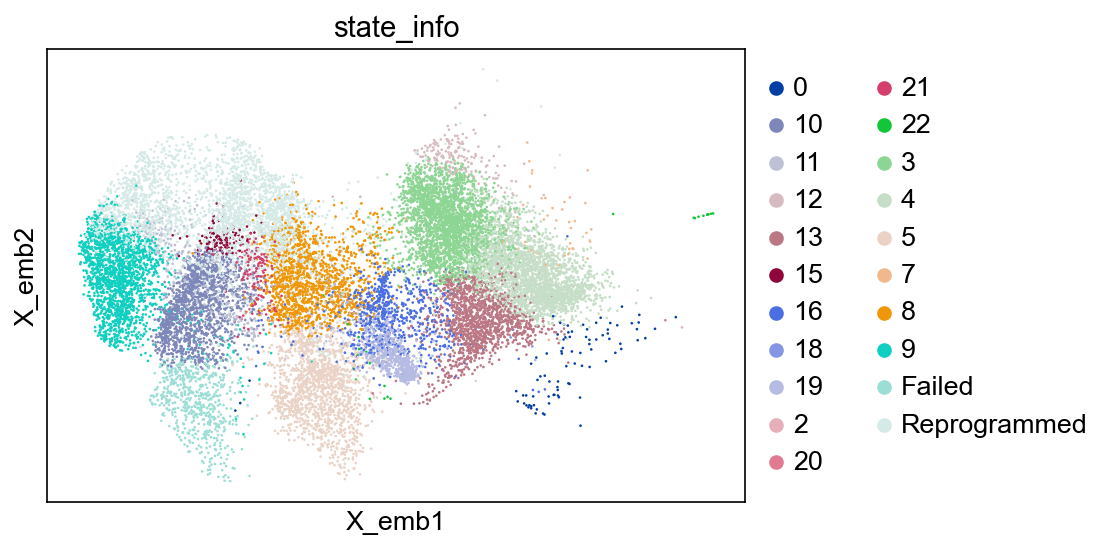

In [5]:
cs.pl.embedding(adata_orig,color='state_info')

In [6]:
cs.hf.check_available_choices(adata_orig)

Available transition maps: []
Availabel clusters: ['19', '2', '20', '18', 'Failed', '9', '13', '8', '11', '15', '16', '5', '10', '12', '4', '22', '3', '0', '7', '21', 'Reprogrammed']
Availabel time points: ['6', '4', '3', '5', '7', '8']
Clonal time points: ['6', '4', '3', '5', '7', '8']


### Raw clonal data analysis (without using state information)

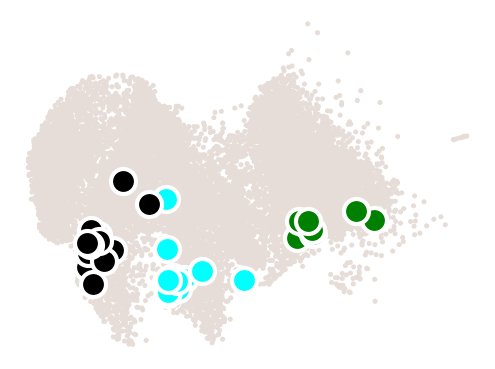

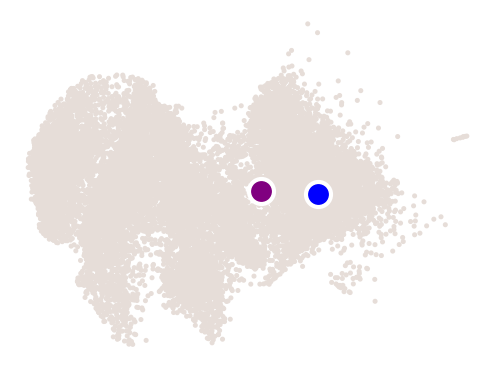

In [7]:
#cs.pl.clones_on_manifold(adata_orig,selected_clone_list=[1],color_list=['black','red','blue'],point_size=2)

cs.pl.clones_on_manifold(adata_orig,selected_clone_list=[324,313],point_size=2) #324,313,446,716,367

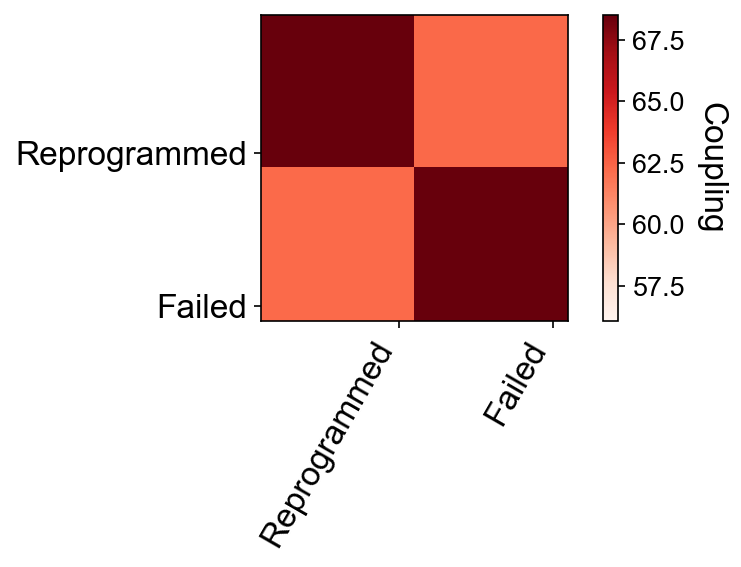

In [8]:
selected_time_point='8'
selected_fates=['Reprogrammed','Failed']
cs.pl.fate_coupling_from_clones(adata_orig,selected_time_point, selected_fates=selected_fates, color_bar=True)

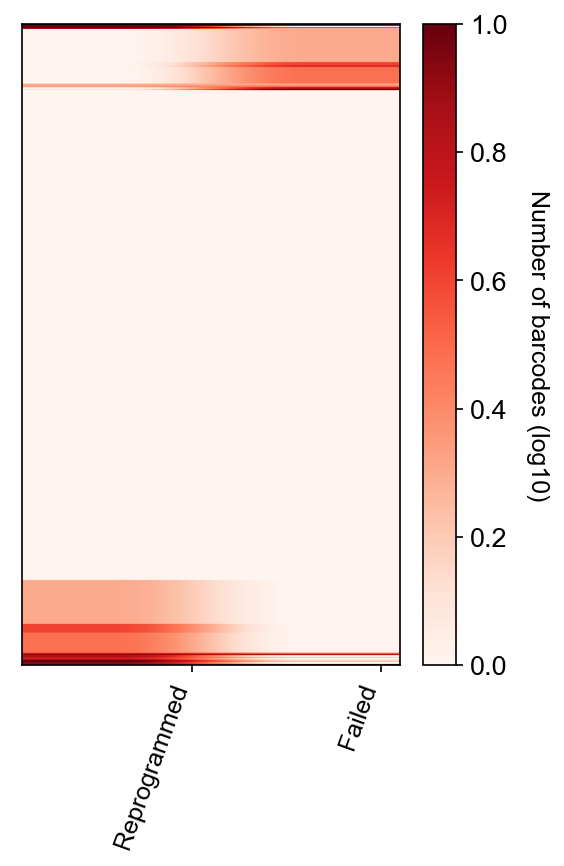

In [9]:
selected_time_point='8'
cs.pl.barcode_heatmap(adata_orig,selected_time_point, selected_fates=selected_fates, color_bar=True)

The computation requires simulation, with time linearly proportional to N_resampling, and the number of clones. Can take hours for big data. 

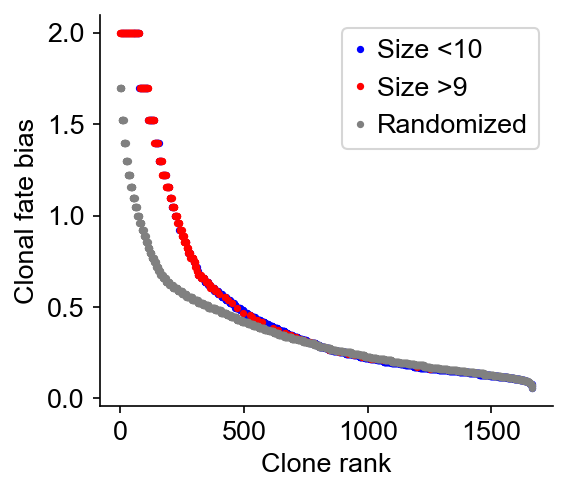

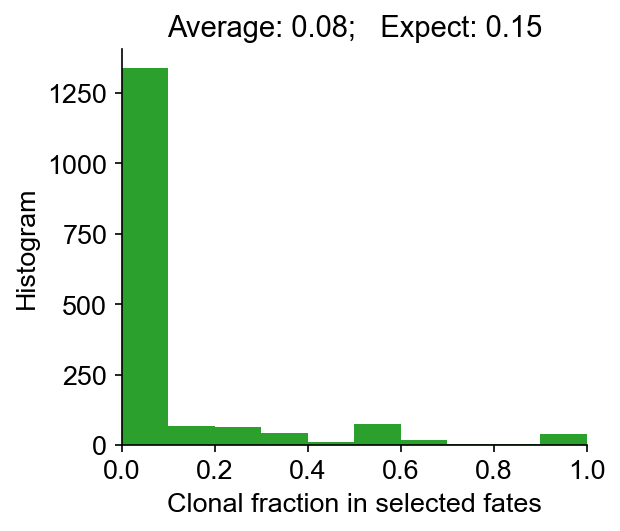

In [10]:
clonal_fate_bias,clone_id=cs.pl.clonal_fate_bias(adata_orig,selected_fate='Reprogrammed',
    clone_size_thresh=10,N_resampling=100,compute_new=False)

## Part 1: Infer transition map using clones from all time points

### Map inference

Running it the first time takes 20 mins, 17 mins of which are used to compute the similarity matrix. When it is run again, it only takes 3 mins.

-------Step 1: Select time points---------
--> Clonal cell fraction (day 3-4): 0.5632183908045977
--> Clonal cell fraction (day 4-5): 0.8427464008859358
--> Clonal cell fraction (day 5-6): 0.8514851485148515
--> Clonal cell fraction (day 6-7): 0.8354622871046229
--> Clonal cell fraction (day 7-8): 0.854301948051948
--> Clonal cell fraction (day 4-3): 0.12181616832779624
--> Clonal cell fraction (day 5-4): 0.7069306930693069
--> Clonal cell fraction (day 6-5): 0.9105839416058394
--> Clonal cell fraction (day 7-6): 0.890625
--> Clonal cell fraction (day 8-7): 0.9279731993299832
--> Numer of cells that are clonally related -- day 3: 49  and day 4: 110
--> Numer of cells that are clonally related -- day 4: 761  and day 5: 2142
--> Numer of cells that are clonally related -- day 5: 2580  and day 6: 2994
--> Numer of cells that are clonally related -- day 6: 2747  and day 7: 4389
--> Numer of cells that are clonally related -- day 7: 4210  and day 8: 6094
Valid clone number 'FOR' post select

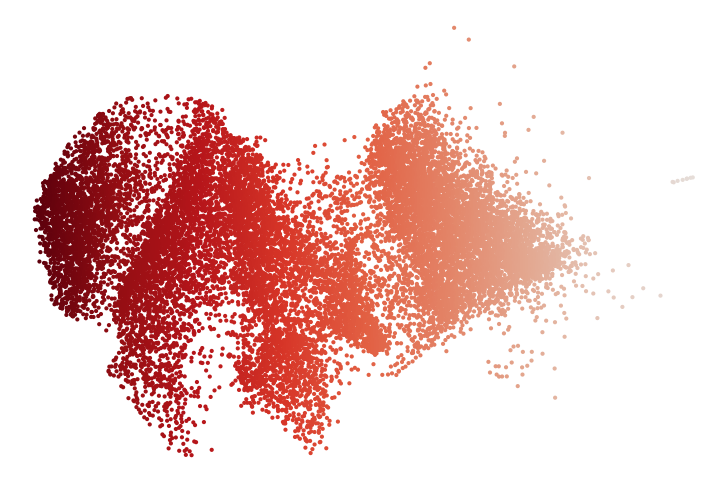

In [11]:
noise_threshold=0.2 # 
selected_clonal_time_points=['3','4','5','6','7','8']
#selected_clonal_time_points=['7','8']
adata=cs.tmap.infer_Tmap_from_multitime_clones(adata_orig,selected_clonal_time_points,smooth_array=[15,10,5],
        noise_threshold=noise_threshold,demulti_threshold=noise_threshold,use_full_Smatrix=True)

### Save or load pre-computed data

This can be used to save maps obtained from different parameter choices.
Usually, different parameter choice will result to different 'data_des', a prefix to define the map.
Saving an adata would print the 'data_des', which can be used to load the corresponding map.

In [12]:
save_data=True
if save_data:
    cs.hf.save_map(adata)
    
load_data=False
if load_data:
    ## Updated Jan 28, 2021
    #data_des='CellTagging_NoConcat_TwoTimeClone_t*3*4*5*6*7*8'
    data_des='CellTagging_NoConcat_OneTimeClone_t*3*4*5*6*7*8'
    adata=cs.hf.load_saved_adata_with_key(data_des)


Saved file: data_des='CellTagging_NoConcat_TwoTimeClone_t*3*4*5*6*7*8'


In [13]:
cs.hf.check_available_choices(adata)

Available transition maps: ['transition_map', 'intraclone_transition_map']
Availabel clusters: ['19', '2', '20', '18', 'Failed', '9', '13', '8', '11', '15', '16', '5', '10', '12', '4', '22', '3', '0', '7', '21', 'Reprogrammed']
Availabel time points: ['6', '4', '3', '5', '7', '8']
Clonal time points: ['6', '4', '3', '5', '7', '8']


### Plotting

#### Plotting transition profiles for single cells

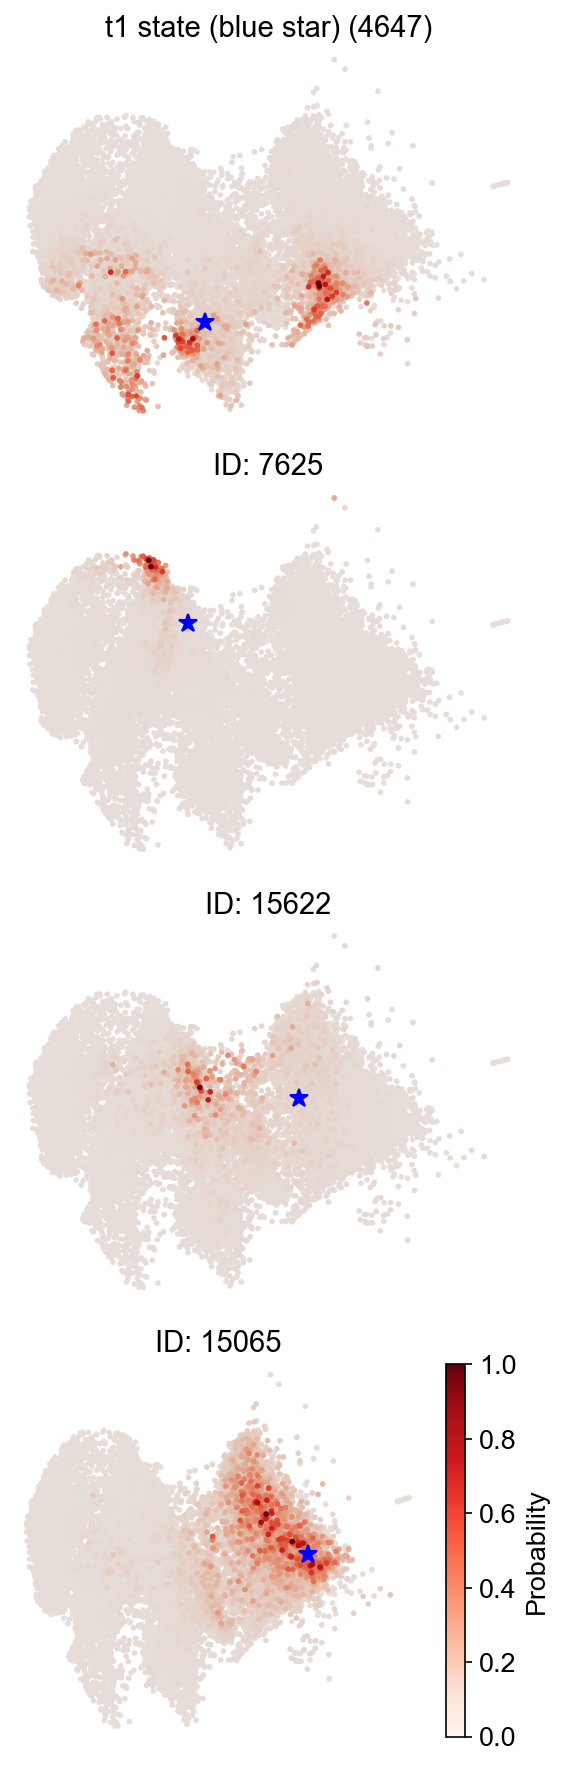

In [14]:
selected_state_id_list=[1000,3500,6000,5500]

cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                                    used_map_name='transition_map',map_backwards=False)

#### Fate map

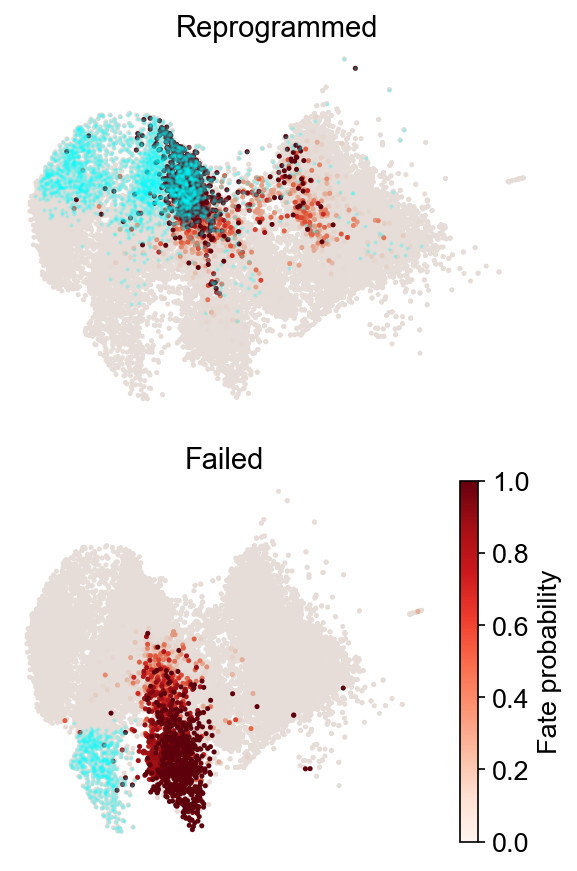

In [15]:
cs.pl.fate_map(adata,selected_fates=['Reprogrammed','Failed'],
               used_map_name='intraclone_transition_map',map_backwards=True,plot_target_state=True)

#### Relative fate bias

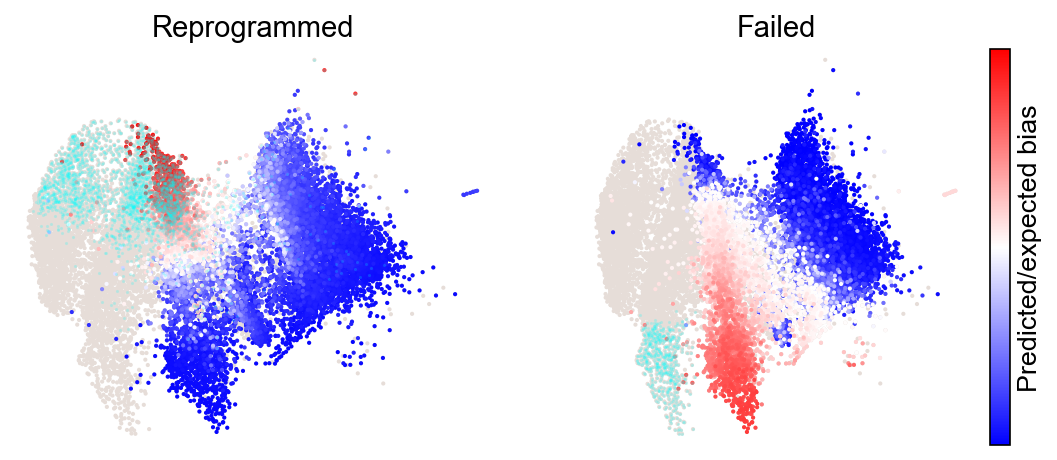

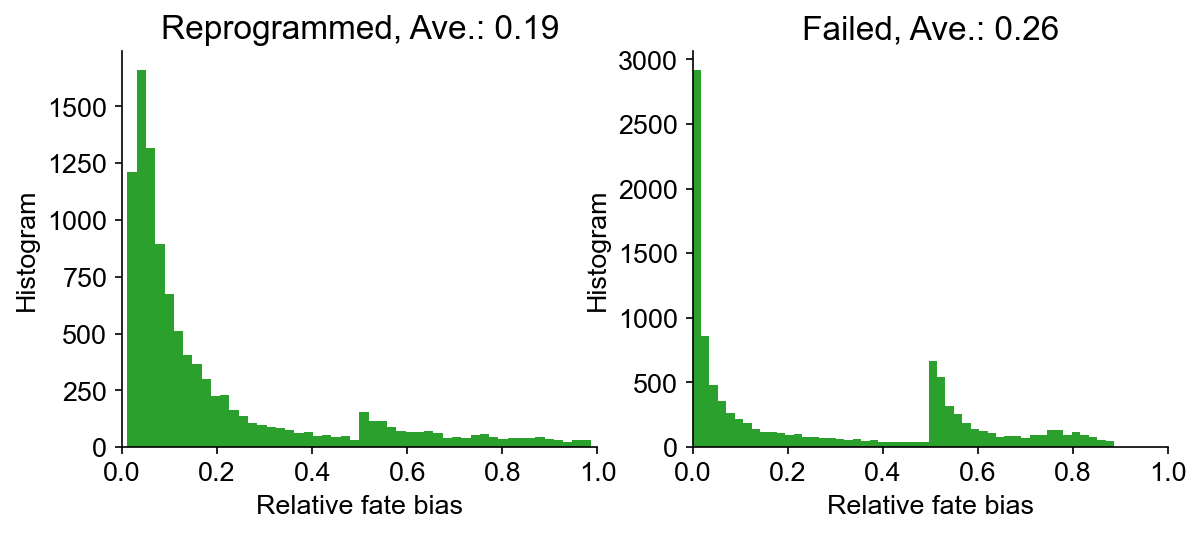

In [16]:
cs.pl.fate_bias_intrinsic(adata,selected_fates=['Reprogrammed','Failed'],used_map_name='transition_map',
            selected_time_points=[],plot_target_state=True,map_backwards=True)

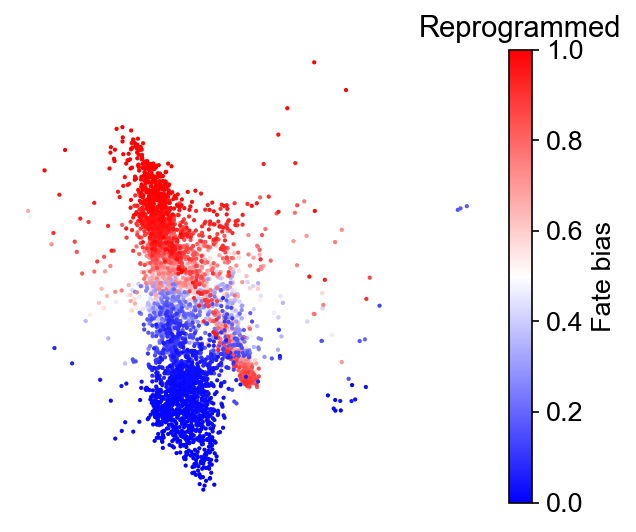

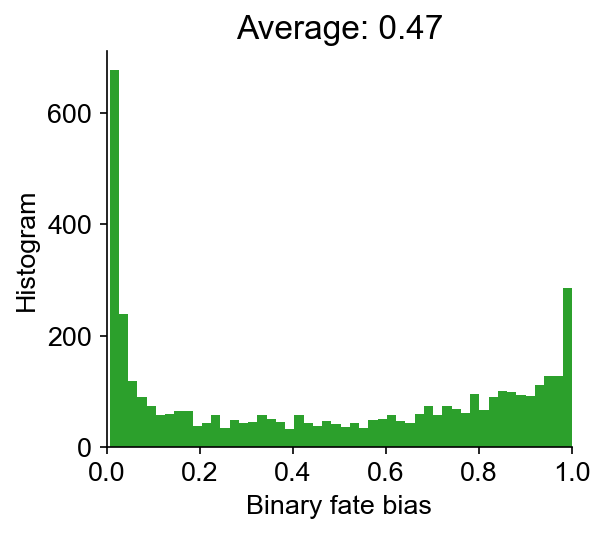

In [17]:
cs.pl.fate_bias_from_binary_competition(adata,selected_fates=['Reprogrammed','Failed'],used_map_name='transition_map',
            selected_time_points=['7'],plot_target_state=False,map_backwards=True,sum_fate_prob_thresh=0)

#### Identify differentially expressed genes

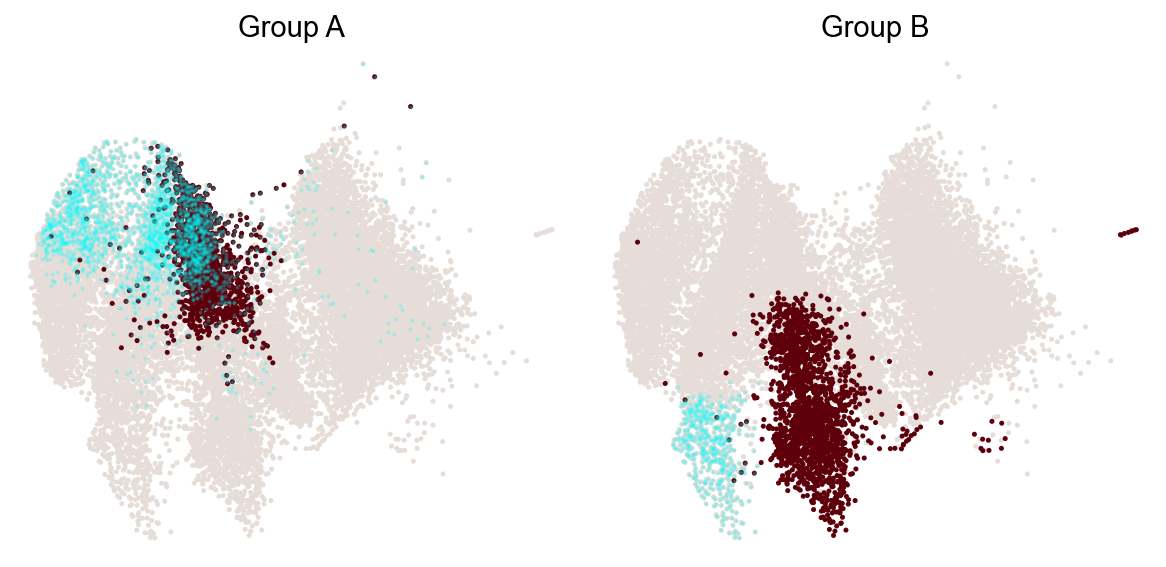

In [18]:
cs.pl.dynamic_trajectory_from_competition_bias(adata, selected_fates=['Reprogrammed','Failed'], 
 used_map_name='transition_map', map_backwards=True, selected_time_points=[],
    bias_threshold=0, sum_fate_prob_thresh=0.2, avoid_target_states=False)


#### Map trajectory backwards iteratively

From our experience, it is better to use the intra-clone transition map to compute the trajectory 

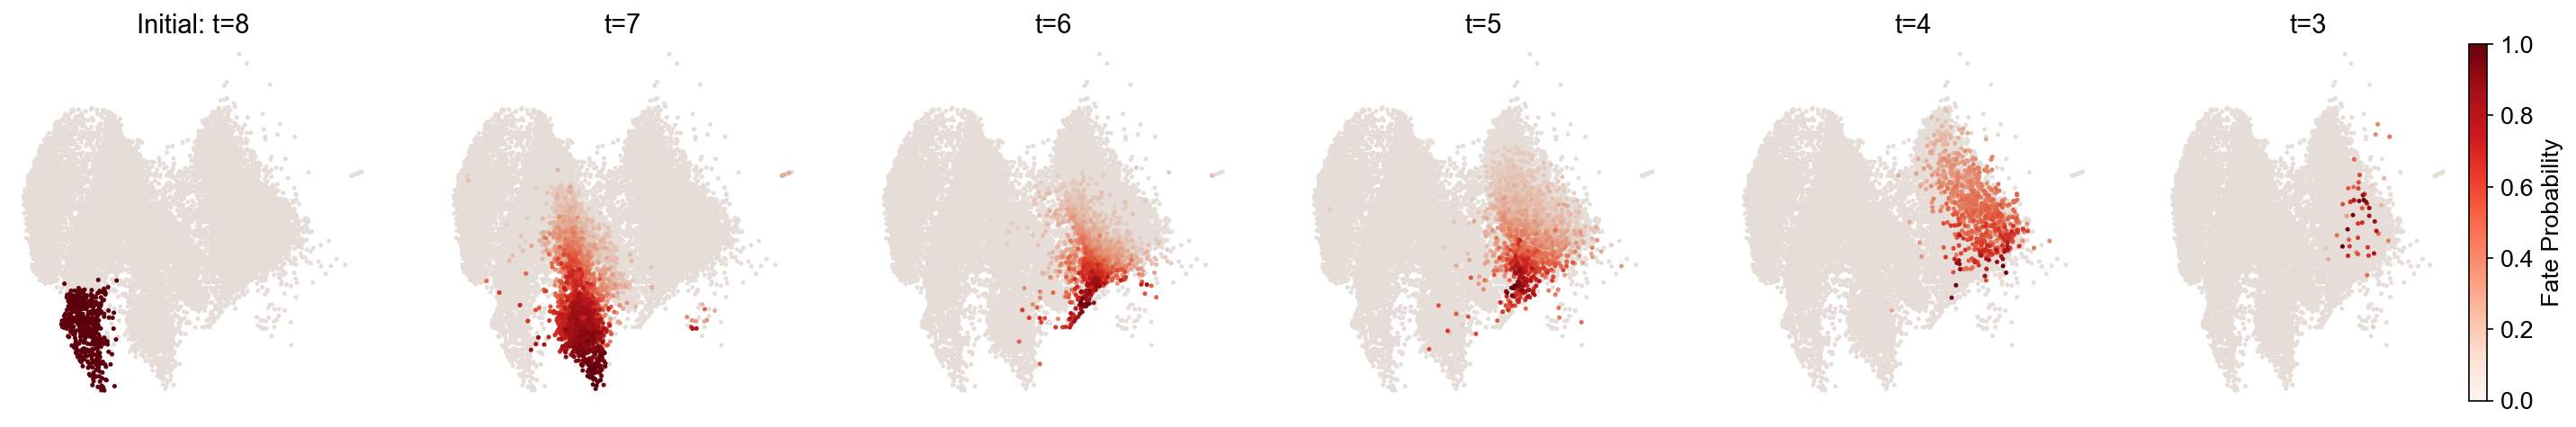

In [19]:
# plot each tiem point separately, use the transition map. 

cs.pl.dynamic_trajectory_via_iterative_mapping(adata,selected_fate='Failed',used_map_name='transition_map',
    map_backwards=True, map_threshold=0.1, plot_separately=True, apply_time_constaint=True, point_size=2)

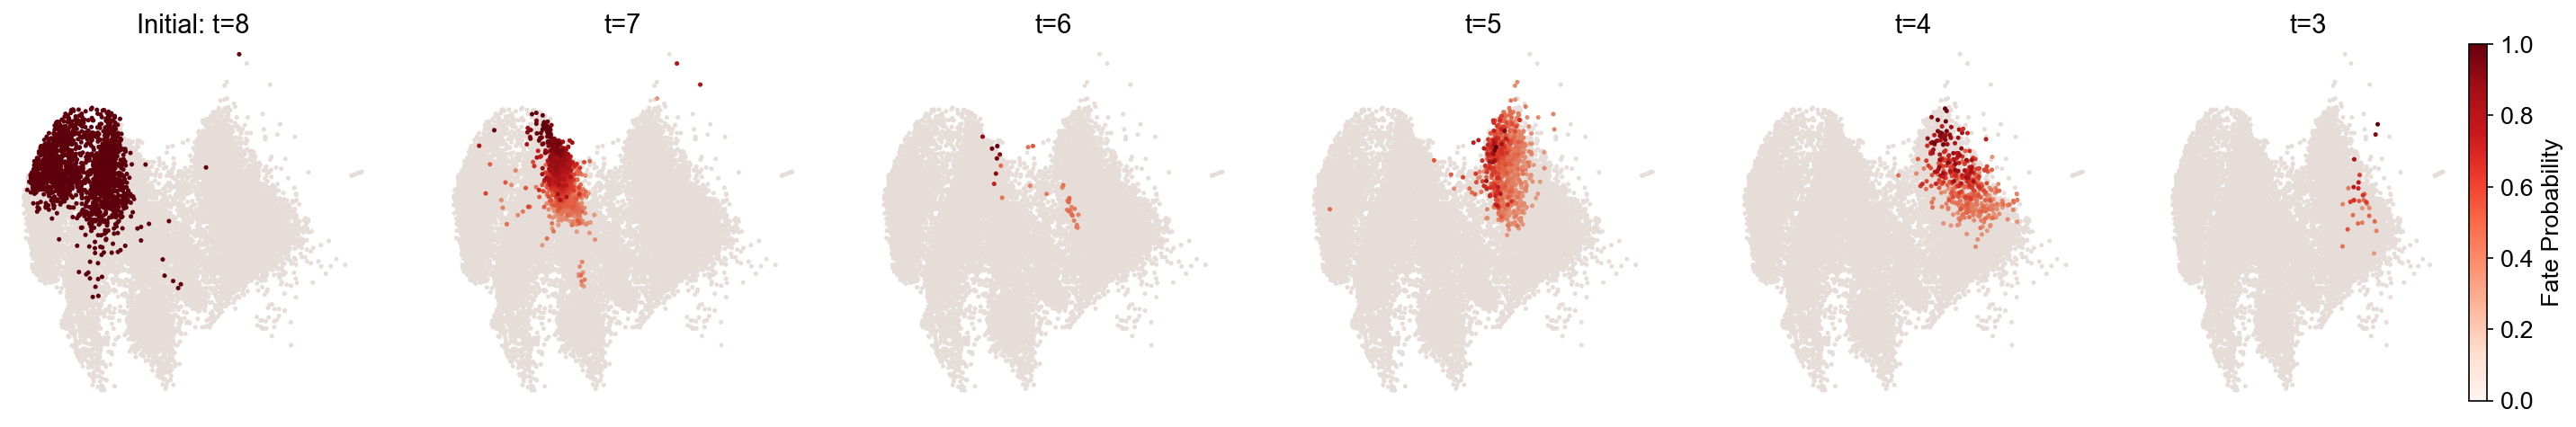

In [20]:
# plot each tiem point separately, use the transition map. 

cs.pl.dynamic_trajectory_via_iterative_mapping(adata,selected_fate='Reprogrammed',used_map_name='transition_map',
    map_backwards=True, map_threshold=0.3, plot_separately=True, apply_time_constaint=True, point_size=2)

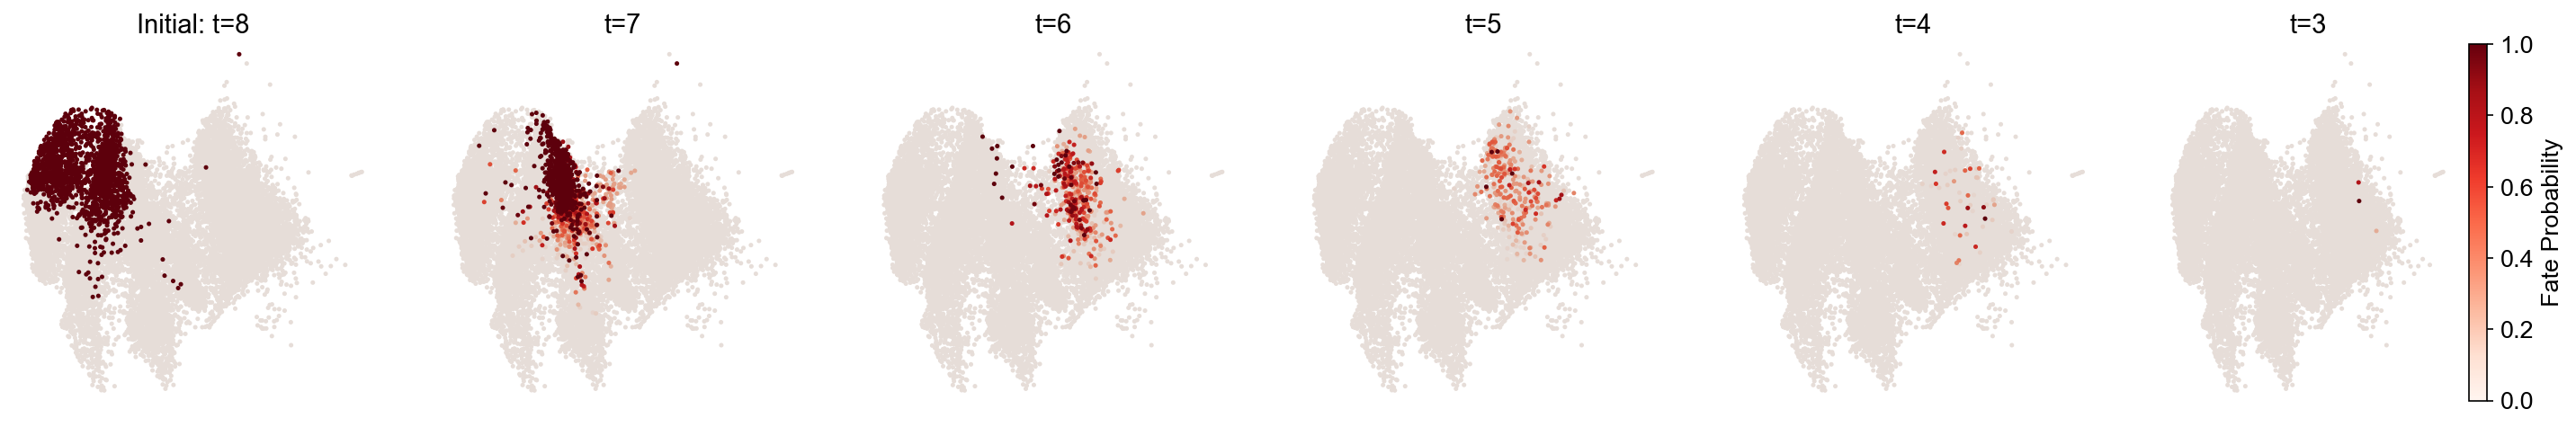

In [21]:
# plot each tiem point separately, use the intra-clone transition map. 
cs.pl.dynamic_trajectory_via_iterative_mapping(adata,selected_fate='Reprogrammed',
                        used_map_name='intraclone_transition_map',
    map_backwards=True, map_threshold=0.05, plot_separately=True, apply_time_constaint=True, point_size=2)

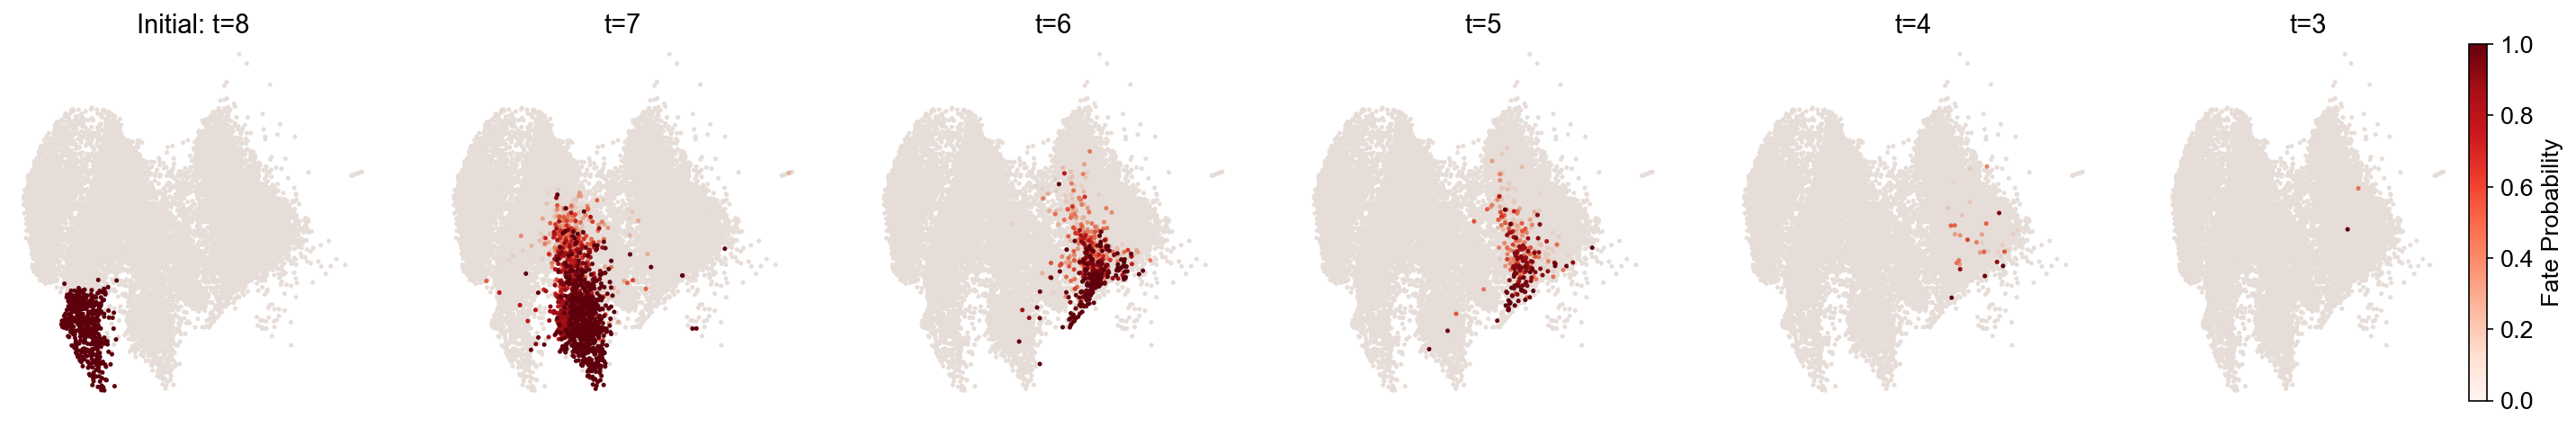

In [22]:
# plot each tiem point separately, use the intra-clone transition map. 
cs.pl.dynamic_trajectory_via_iterative_mapping(adata,selected_fate='Failed',
                        used_map_name='intraclone_transition_map',
    map_backwards=True, map_threshold=0.05, plot_separately=True, apply_time_constaint=True, point_size=2)

#### Gene trend along the trajectory

/Users/shouwenwang/miniconda3/envs/CoSpar_env/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3.5 x 2.163 in image.
/Users/shouwenwang/miniconda3/envs/CoSpar_env/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figure_cospar/CellTagging_NoConcat_TwoTimeClone_t*3*4*5*6*7*8_fate_trajectory_pseutoTime_gene_expression_Failed_True.png


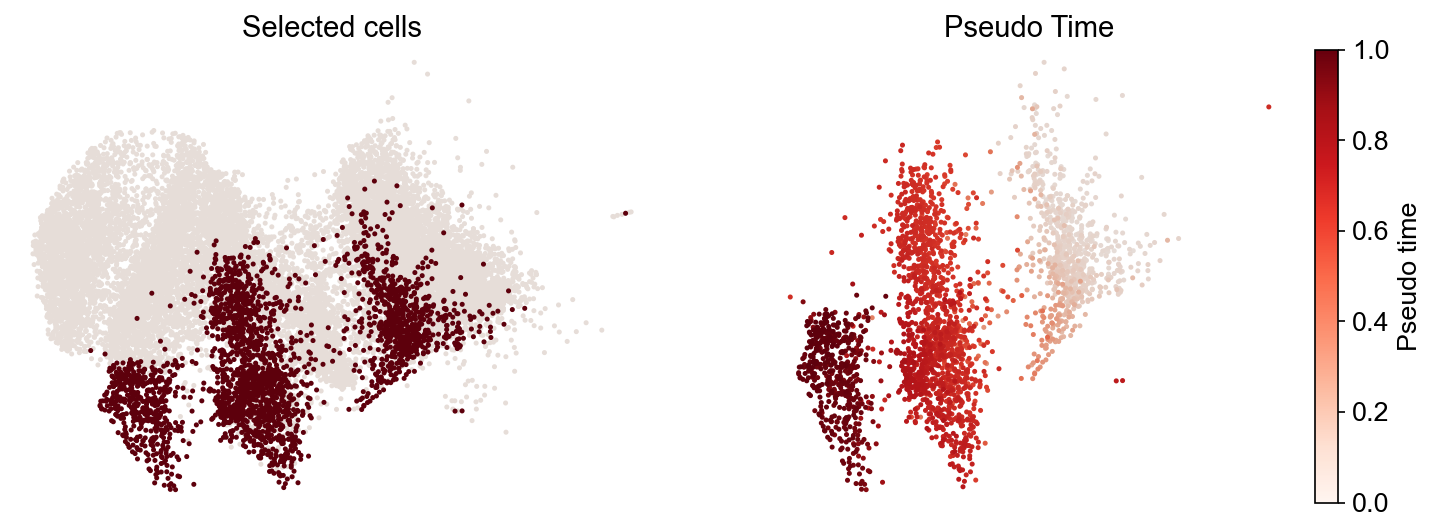

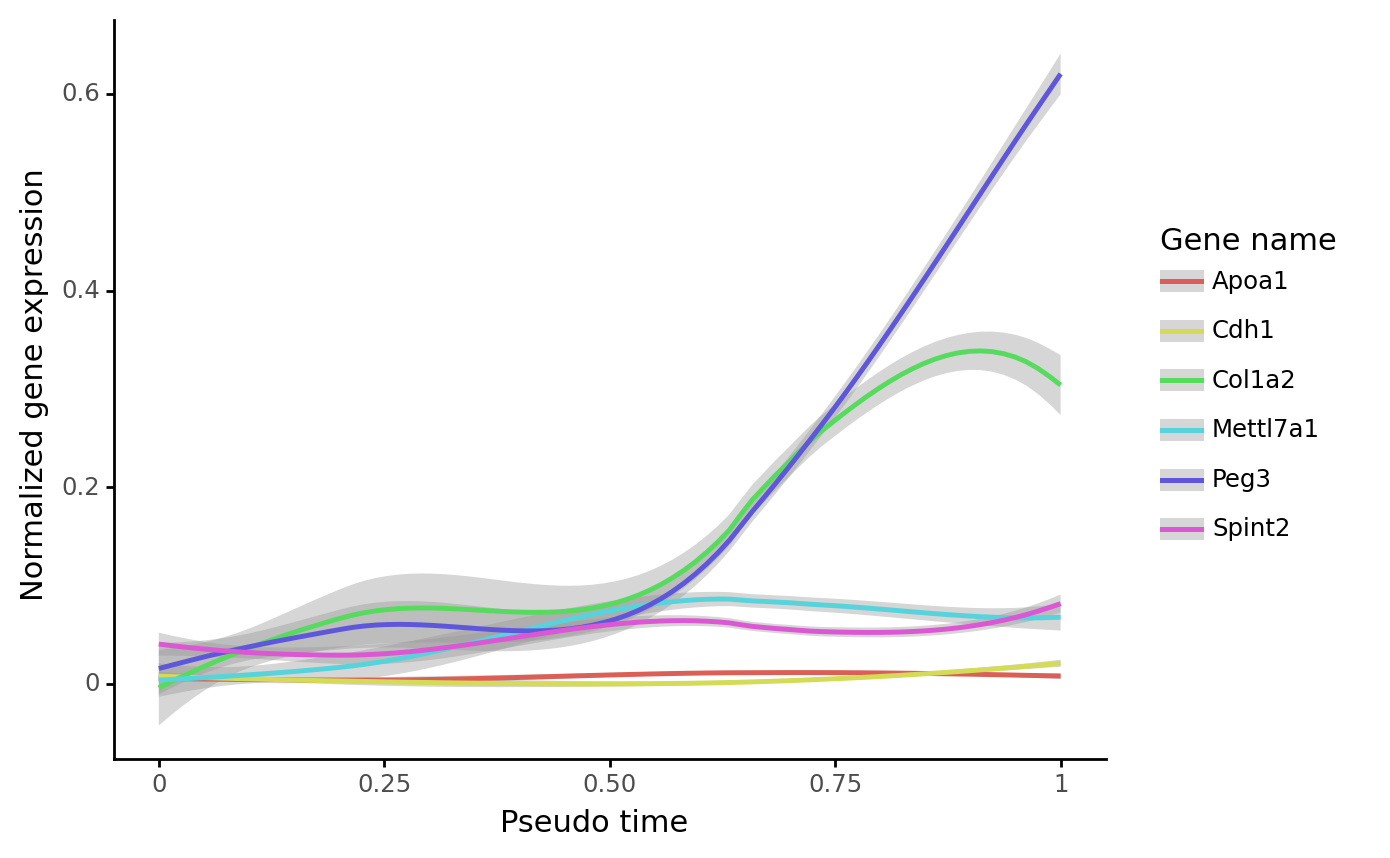

In [23]:
# The results are based on pre-computed dynamic trajectories from the immediate previous step
# better to use the 'intraclone transition map'

gene_name_list=['Col1a2','Apoa1','Peg3','Spint2','Mettl7a1','Cdh1']
selected_fate='Failed'
adata_selected=cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.1,  
      map_backwards=True, invert_PseudoTime=True, include_target_states=True, compute_new=True, 
    fig_width=3.5, gene_exp_percentile=99, n_neighbors=8, plot_raw_data=False, point_size=2)


/Users/shouwenwang/miniconda3/envs/CoSpar_env/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3.5 x 2.163 in image.
/Users/shouwenwang/miniconda3/envs/CoSpar_env/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figure_cospar/CellTagging_NoConcat_TwoTimeClone_t*3*4*5*6*7*8_fate_trajectory_pseutoTime_gene_expression_Reprogrammed_True.png


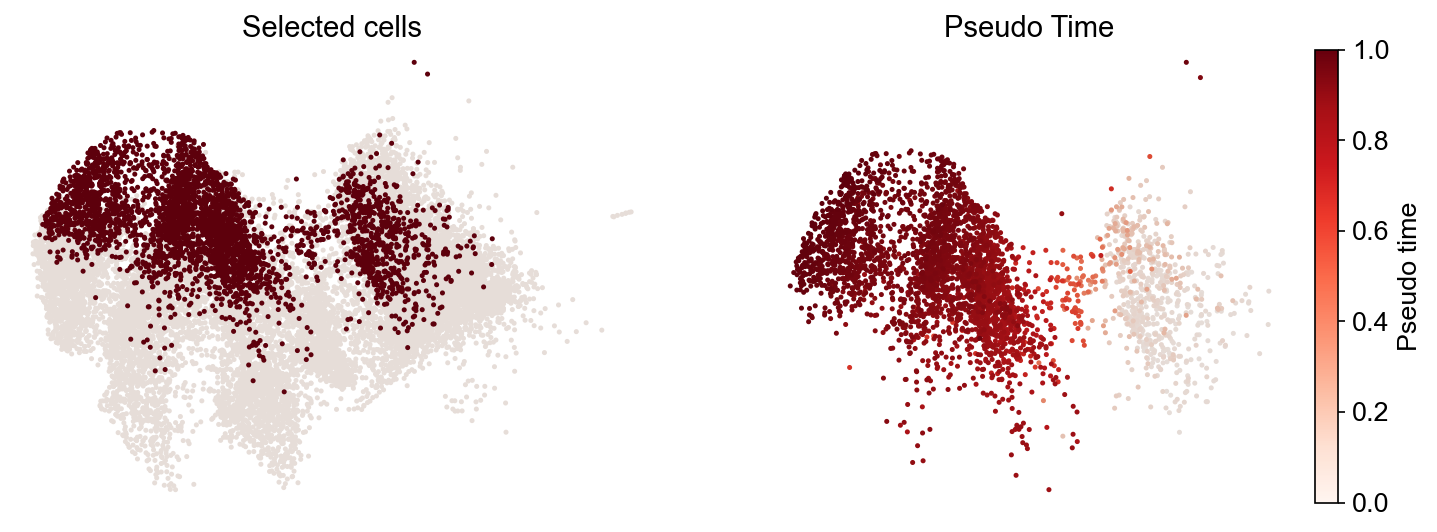

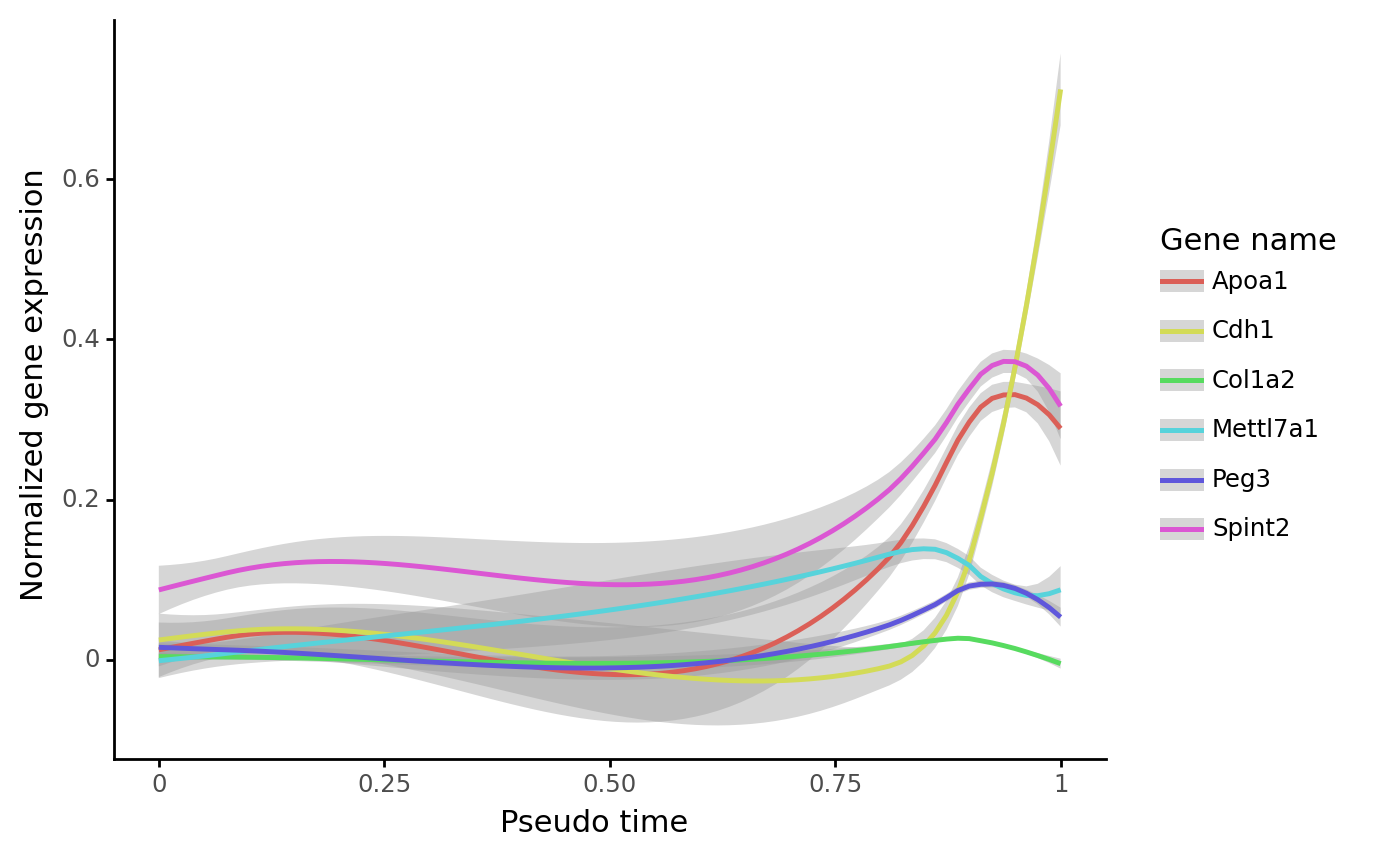

In [24]:
# The results are based on pre-computed dynamic trajectories from a previous step
# better to use the 'intraclone transition map'

gene_name_list=['Col1a2','Apoa1','Peg3','Spint2','Mettl7a1','Cdh1']
selected_fate='Reprogrammed'
adata_selected=cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.1,  
      map_backwards=True, invert_PseudoTime=True, include_target_states=True, compute_new=True, 
    fig_width=3.5, gene_exp_percentile=99, n_neighbors=8, plot_raw_data=False, point_size=2)


### Transition map from only clonal information

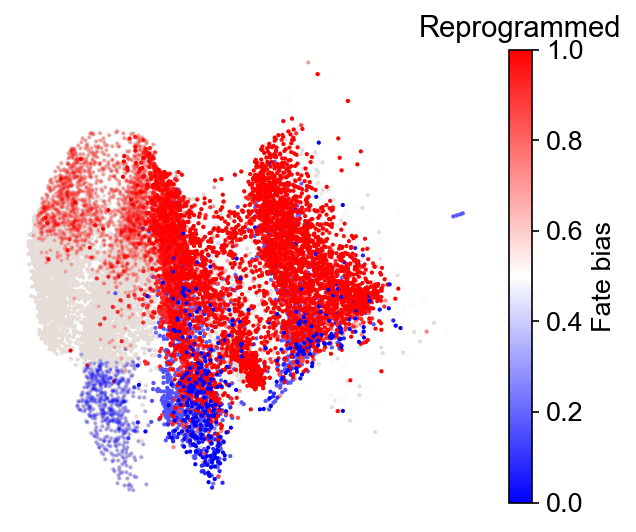

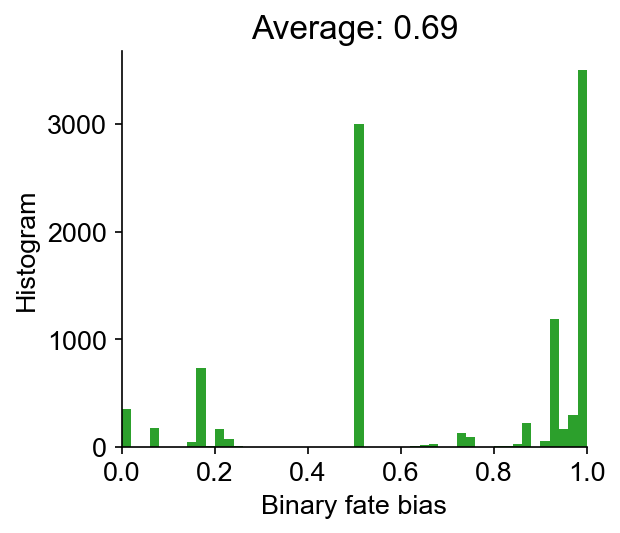

In [25]:
cs.tmap.infer_Tmap_from_clonal_info_alone(adata,method='naive')

cs.pl.fate_bias_from_binary_competition(adata,selected_fates=['Reprogrammed','Failed'],used_map_name='clonal_transition_map',
            selected_time_points=[],plot_target_state=True,map_backwards=True,sum_fate_prob_thresh=0)

## Part II: Infer transition map using clones from the last time point

It takes 12 mins to compute for the first time (excluding the time for computing similarity matrix); and 5 mins later. 

In [26]:
initial_time_points=['3','4','5','6','7']
clonal_time_point='8'
adata=cs.tmap.infer_Tmap_from_one_time_clones(adata_orig,initial_time_points,clonal_time_point,
        initialize_method='OT',OT_cost='SPD',smooth_array=[15,10,5],noise_threshold=0.2,use_full_Smatrix=True)

-------------------------------New Start--------------------------------------------------
Current time point: 3
-----------Pre-processing and sub-sampling cells------------
----------------
Step 1: Use OT method for initialization
Load pre-computed shortest path distance matrix
Load pre-computed custon OT matrix
----------------
Step 2: Jointly optimize the transition map and the initial clonal states!
Joint optimization that consider possibility of clonal overlap: v2
--> original clone shape: (6654, 770)
--> After excluding zero-sized clones at t2: (6654, 694)
Sort clones by size (small to large)
Infer the number of initial cells to extract for each clone in advance
--> Inferring early clonal states: current clone id 0
--> Inferring early clonal states: current clone id 100
--> Inferring early clonal states: current clone id 200
--> Inferring early clonal states: current clone id 300
--> Inferring early clonal states: current clone id 400
--> Inferring early clonal states: current cl

Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
Start to smooth the refined clonal map
Phase I: time elapsed --  1.9691081047058105
Phase II: time elapsed --  2.8161470890045166
Current iteration: 2
Use smooth_round=5
Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
Start to smooth the refined clonal map
Phase I: time elapsed --  1.2565879821777344
Phase II: time elapsed --  1.7074029445648193
Final round of Smooth (to expand the state space of Tmap to include non-clonal states)
Phase I: time elapsed --  1.3795409202575684
Phase II: time elapsed --  1.9576280117034912
----Demultiplexed transition map----
Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0
Finishing computing transport map from CoSpar using inferred clonal data, used time 66.69856905937195
-------------------------------New Start--------------------------------------------------
Current time point: 6
-----------Pre-processing and sub-sampling cells

In [27]:
cs.hf.check_available_choices(adata)

Available transition maps: ['transition_map', 'OT_transition_map']
Availabel clusters: ['19', '2', '20', '18', 'Failed', '9', '13', '8', '11', '15', '16', '5', '10', '12', '4', '22', '3', '0', '7', '21', 'Reprogrammed']
Availabel time points: ['6', '4', '3', '5', '7', '8']
Clonal time points: ['6', '4', '3', '5', '7', '8']


#### Plot fate map

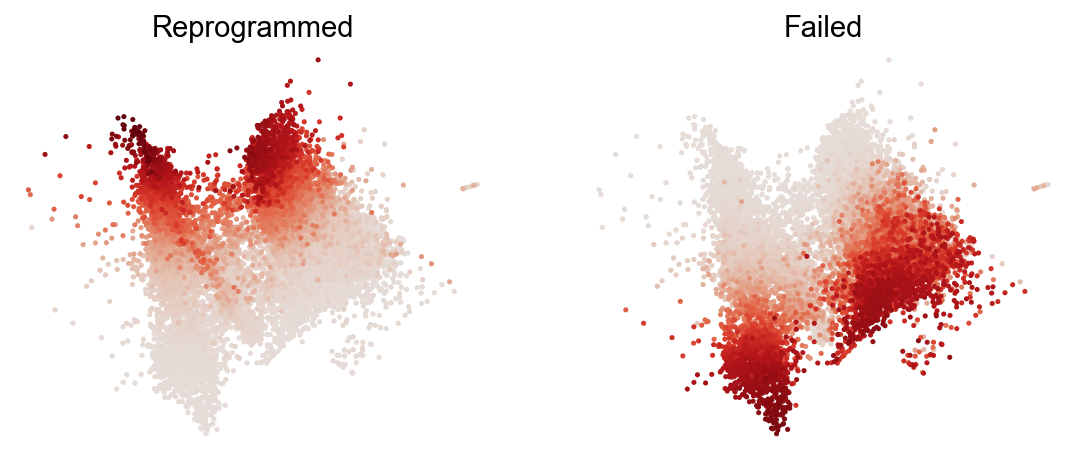

In [28]:
cs.pl.fate_map(adata,selected_fates=['Reprogrammed','Failed'],
               used_map_name='transition_map',map_backwards=True,plot_target_state=False,
               color_bar=False,background=False,auto_color_scale=False,horizontal=True)

#### Plot binary fate choice

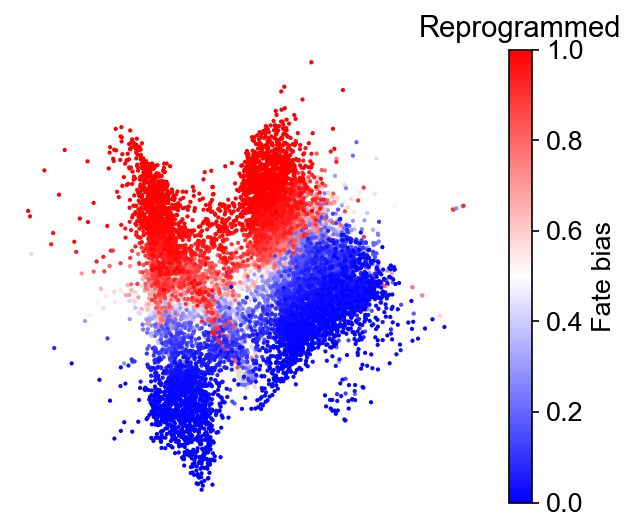

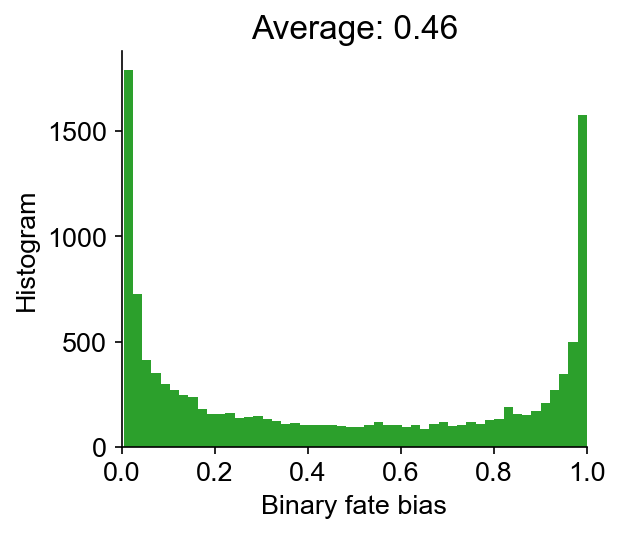

In [29]:
cs.pl.fate_bias_from_binary_competition(adata,selected_fates=['Reprogrammed','Failed'],used_map_name='transition_map',
            selected_time_points=[],plot_target_state=False,map_backwards=True,sum_fate_prob_thresh=0.1)

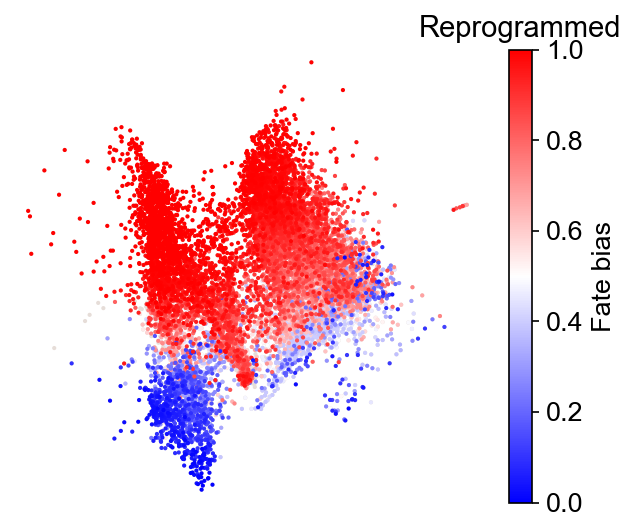

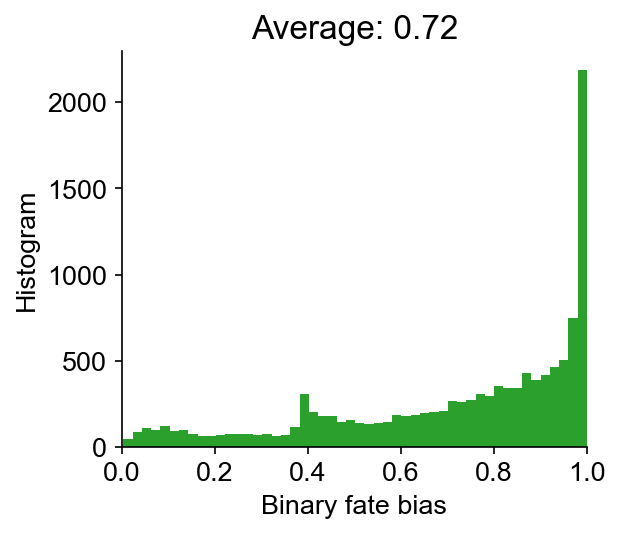

In [30]:
cs.pl.fate_bias_from_binary_competition(adata,selected_fates=['Reprogrammed','Failed'],used_map_name='OT_transition_map',
            selected_time_points=[],plot_target_state=False,map_backwards=True,sum_fate_prob_thresh=0.1)

#### Dynamic trajectory inference

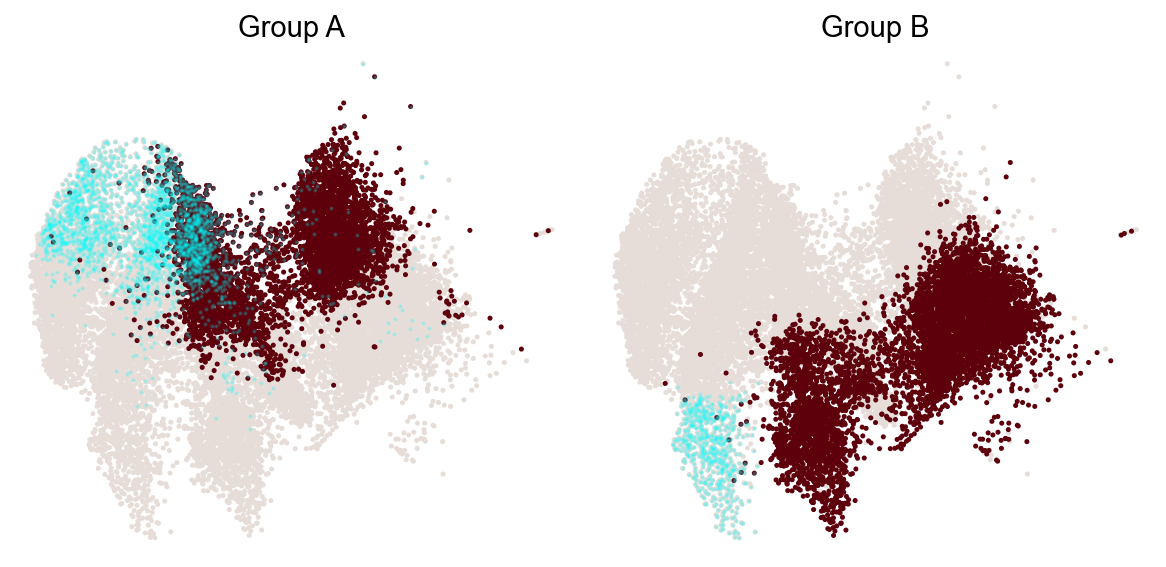

In [31]:
cs.pl.dynamic_trajectory_from_competition_bias(adata, selected_fates=['Reprogrammed','Failed'], 
 used_map_name='transition_map', map_backwards=True, selected_time_points=[],
    bias_threshold=0, sum_fate_prob_thresh=0.2, avoid_target_states=False)


#### Gene trend along the dynamic trajectory

The selected states, combined with the target states are stored as dynamic trajectory at `adata.uns['dynamic_trajectory']`.
We can plot gene trend along this trajectory.

/Users/shouwenwang/miniconda3/envs/CoSpar_env/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3.5 x 2.163 in image.
/Users/shouwenwang/miniconda3/envs/CoSpar_env/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figure_cospar/CellTagging_NoConcat_OneTimeClone_t*3*4*5*6*7*8_fate_trajectory_pseutoTime_gene_expression_Reprogrammed_True.png


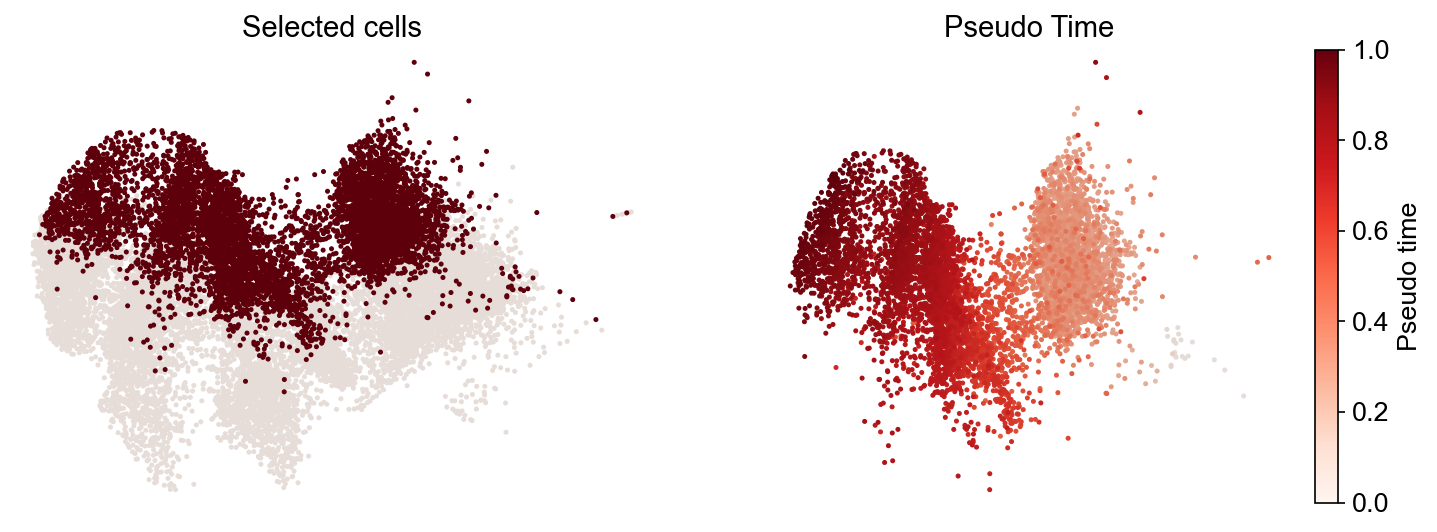

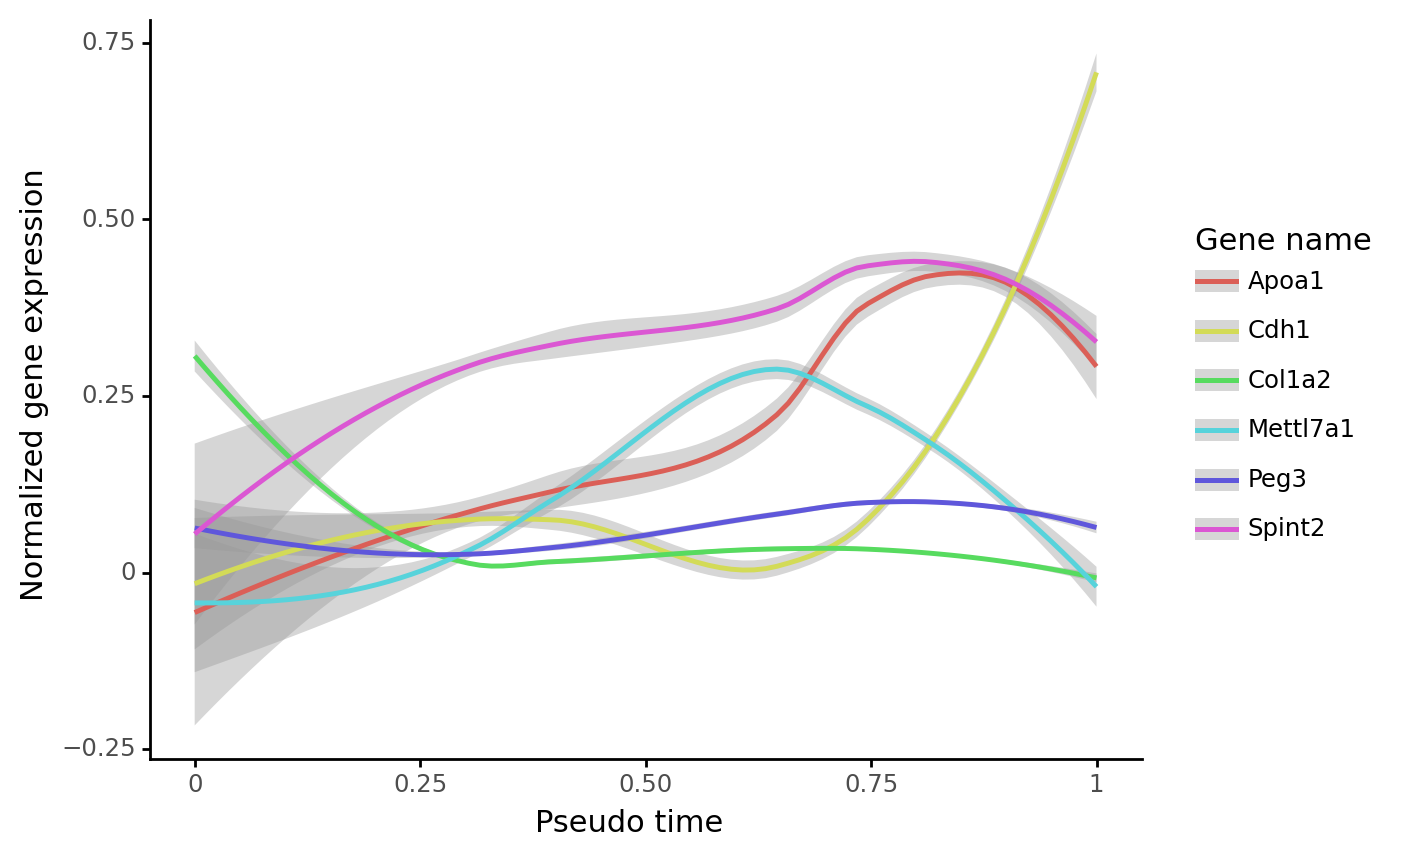

In [32]:
gene_name_list=['Col1a2','Apoa1','Peg3','Spint2','Mettl7a1','Cdh1']
selected_fate='Reprogrammed'
adata_selected=cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.2,  
      map_backwards=True, invert_PseudoTime=True, include_target_states=True)
